# import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
# light blue and orange
correct_color = "tab:blue"
incorrect_color = "tab:orange"

/home/nakagawa/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# define functions

In [2]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

def preprocess_df(raw_df:pd.DataFrame, true_label:pd.DataFrame)->pd.DataFrame:
    df = raw_df.copy()
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    min_max_func = lambda x: (x - x.min()) / (x.max() - x.min()) # min-max normalization
    convert_probability_func = lambda x: x / x.sum() # convert to binary
    processed_df = df.apply(min_max_func, axis=1).apply(convert_probability_func, axis=1)
    processed_df.columns = LABELS
    processed_df["predict_probability"] = processed_df.max(axis=1)
    processed_df["predict_label"] = processed_df.idxmax(axis=1)
    processed_df['true_label'] = true_label.map(lambda x: LABELS[x])
    return processed_df

def show_count(processed_df, title):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color])
    plt.title(f'{title}\nPredict Probability Count\nACC: {acc:.4f}')
    plt.xlim(0, 1)
    plt.ylim(0, 400)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    plt.savefig(f'assets/{title}-count.png')
    plt.show()

def show_count_stacked(processed_df, title, split_size=0.01):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df = df.loc[:,['incorrect', 'correct',]]
    correct_list = list()
    incorrect_list = list()
    split_num = int(1/split_size)
    for i in range(split_num,0,-1):
        i *= split_size
        correct_list.append((df.correct>i).sum())
        incorrect_list.append((df.incorrect>i).sum())
    correct_list.reverse()
    incorrect_list.reverse()
    plt.bar(np.arange(split_num)*split_size, incorrect_list, width=split_size, color=incorrect_color)
    plt.bar(np.arange(split_num)*split_size, correct_list, width=split_size, color=correct_color, bottom=incorrect_list)
    plt.title(f'{title}\nPredict Probability Stacked Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    plt.savefig(f'assets/{title}-count-stacked.png')
    plt.show()

def show_confusion_matrix(df, title):
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    cm = confusion_matrix(df['true_label'], df['predict_label'], labels=LABELS)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=LABELS, yticklabels=LABELS)
    plt.title(f'{title}\nConfusion Matrix\nACC: {calc_accuracy(df):.4f}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig(f'assets/{title}-confusion-matrix.png')
    plt.show()

def calc_thredshold_df(df):
    thresholds = [i*0.1 for i in range(11)]
    acc_list = list()
    count_list = list()
    for threshold in thresholds:
        acc_list.append(calc_accuracy(df.loc[df.predict_probability>threshold]))
        count_list.append(len(df.loc[df.predict_probability>threshold]))
    threshold_df = pd.DataFrame({'threshold': thresholds, 'accuracy': acc_list, 'count': count_list})
    return threshold_df.set_index('threshold')

# load data

In [3]:
cnn1d_raw_df = pd.read_csv('../cnn1d/predict.csv', index_col=0).drop(columns=["true"])
convbbt_raw_df = pd.read_csv('../convbbt/predict.csv', index_col=0).drop(columns=["true"])
vit_raw_df = pd.read_csv('../vit/predict.csv', index_col=0).drop(columns=["true"])
true_label = pd.read_csv('../convbbt/predict.csv', index_col=0)["true"]

# check data

## raw data head

In [4]:
cnn1d_raw_df.head()

,0,1,2,3,4,5
0,-41.391300,-19.525230,-41.098103,-40.247326,8.594010,16.886126
1,-23.017810,-37.092327,32.698044,1.198529,-7.665591,-26.310192
2,-25.394966,-44.099842,-50.211735,-58.358400,23.554977,-7.026921
3,-3.719642,33.317510,-86.934020,-88.753174,-1.316395,-32.161095
4,-12.965935,-19.494660,-0.595499,12.329179,2.745328,-19.452412


In [5]:
vit_raw_df.head()

,0,1,2,3,4,5
0,3.011206,-5.817851,-5.217103,-7.638794,0.831200,9.454015
1,1.910253,-6.772700,15.421850,2.738583,-5.358047,-3.725187
2,-1.027743,-7.089542,-5.357136,-3.138410,12.560061,1.079521
3,-2.923320,15.512492,-7.420484,-7.753412,1.668159,-0.424469
4,1.624771,-4.469953,-0.402944,15.373968,-4.972460,-5.154066


In [6]:
convbbt_raw_df.head()

,0,1,2,3,4,5
0,2.667278,-6.223639,-10.455910,-7.705863,3.942457,5.992100
1,-3.501386,-5.147262,15.075128,7.256400,-0.475929,-2.861587
2,3.822823,-9.720933,-9.241361,-5.683146,6.891798,3.425873
3,3.279096,11.735168,-4.228587,-1.351361,-4.169562,-4.644408
4,-2.105618,-2.101908,0.199927,13.780579,-3.819936,-1.524870


In [7]:
cnn1d_df = preprocess_df(cnn1d_raw_df, true_label)
convbbt_df = preprocess_df(convbbt_raw_df, true_label)
vit_df = preprocess_df(vit_raw_df, true_label)

## processed data head

In [8]:
cnn1d_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.000000,0.166199,0.002229,0.008695,0.379926,0.442952,0.442952,Walking,Walking
1,0.086685,0.000000,0.429837,0.235833,0.181239,0.066407,0.429837,Sitting,Sitting
2,0.174767,0.075597,0.043192,0.000000,0.434292,0.272152,0.434292,Upstairs,Upstairs
3,0.240921,0.345856,0.005154,0.000000,0.247730,0.160339,0.345856,Jogging,Jogging
4,0.082087,0.000000,0.237624,0.400129,0.279629,0.000531,0.400129,Standing,Standing


In [9]:
vit_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.263253,0.045011,0.059861,0.000000,0.209366,0.422510,0.422510,Walking,Walking
1,0.193596,0.000000,0.494851,0.212064,0.031541,0.067948,0.494851,Sitting,Sitting
2,0.153215,0.000000,0.043787,0.099867,0.496654,0.206477,0.496654,Upstairs,Upstairs
3,0.106909,0.514967,0.007369,0.000000,0.208537,0.162219,0.514967,Jogging,Jogging
4,0.205895,0.020779,0.144307,0.623503,0.005516,0.000000,0.623503,Standing,Standing


In [10]:
convbbt_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.257560,0.083064,0.000000,0.053973,0.282588,0.322815,0.322815,Walking,Walking
1,0.039920,0.000000,0.490490,0.300848,0.113302,0.055439,0.490490,Sitting,Sitting
2,0.283220,0.000000,0.010029,0.084436,0.347397,0.274919,0.347397,Upstairs,Upstairs
3,0.278147,0.574988,0.014597,0.115599,0.016669,0.000000,0.574988,Jogging,Jogging
4,0.062686,0.062821,0.146990,0.643581,0.000000,0.083921,0.643581,Standing,Standing


# Each Model

# frequency of each model

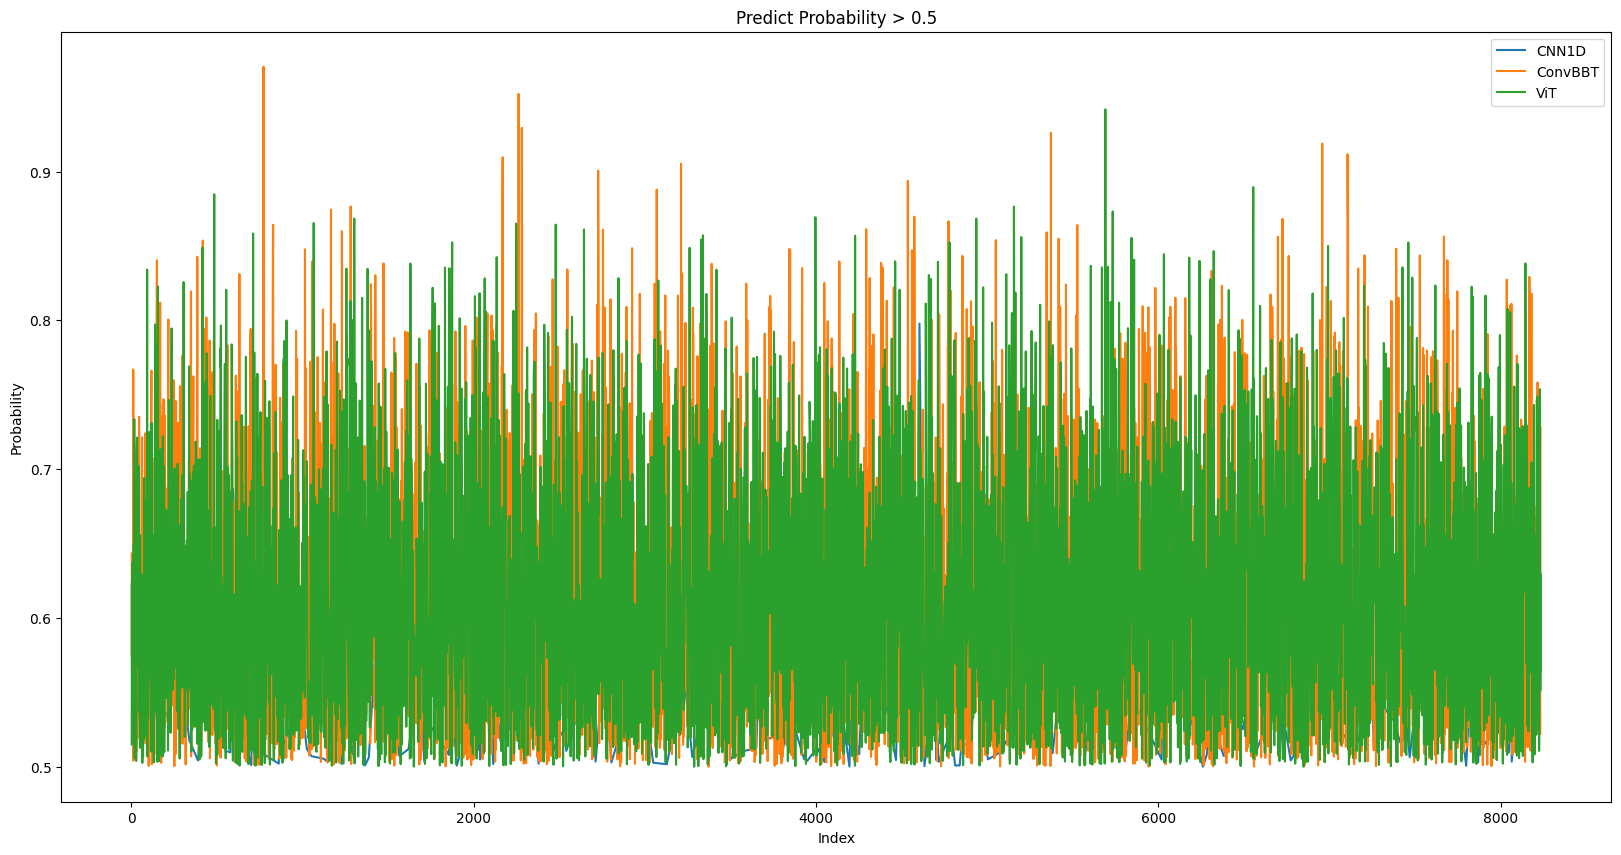

In [11]:
plt.rcParams['figure.figsize'] = [20, 10]
threshold = 0.5
cnn1d_df.loc[cnn1d_df.predict_probability>threshold,'predict_probability'].plot()
convbbt_df.loc[convbbt_df.predict_probability>threshold,'predict_probability'].plot()
vit_df.loc[vit_df.predict_probability>threshold,'predict_probability'].plot()
plt.title(f'Predict Probability > {threshold}')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.legend(['CNN1D', 'ConvBBT', 'ViT'])

## count

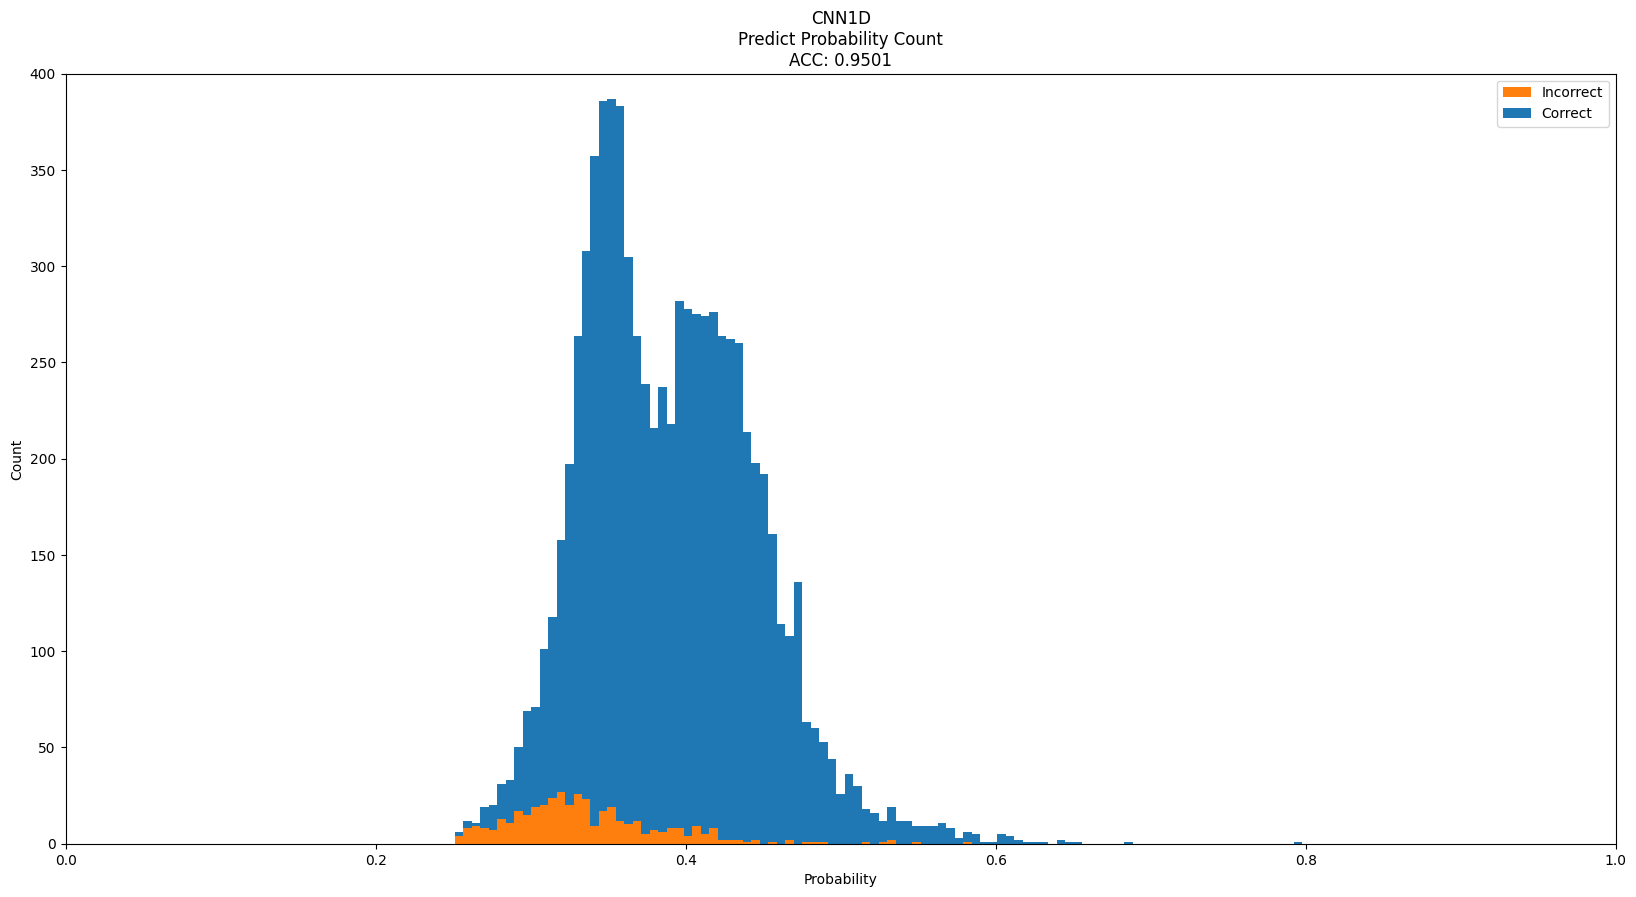

In [12]:
show_count(cnn1d_df, 'CNN1D')

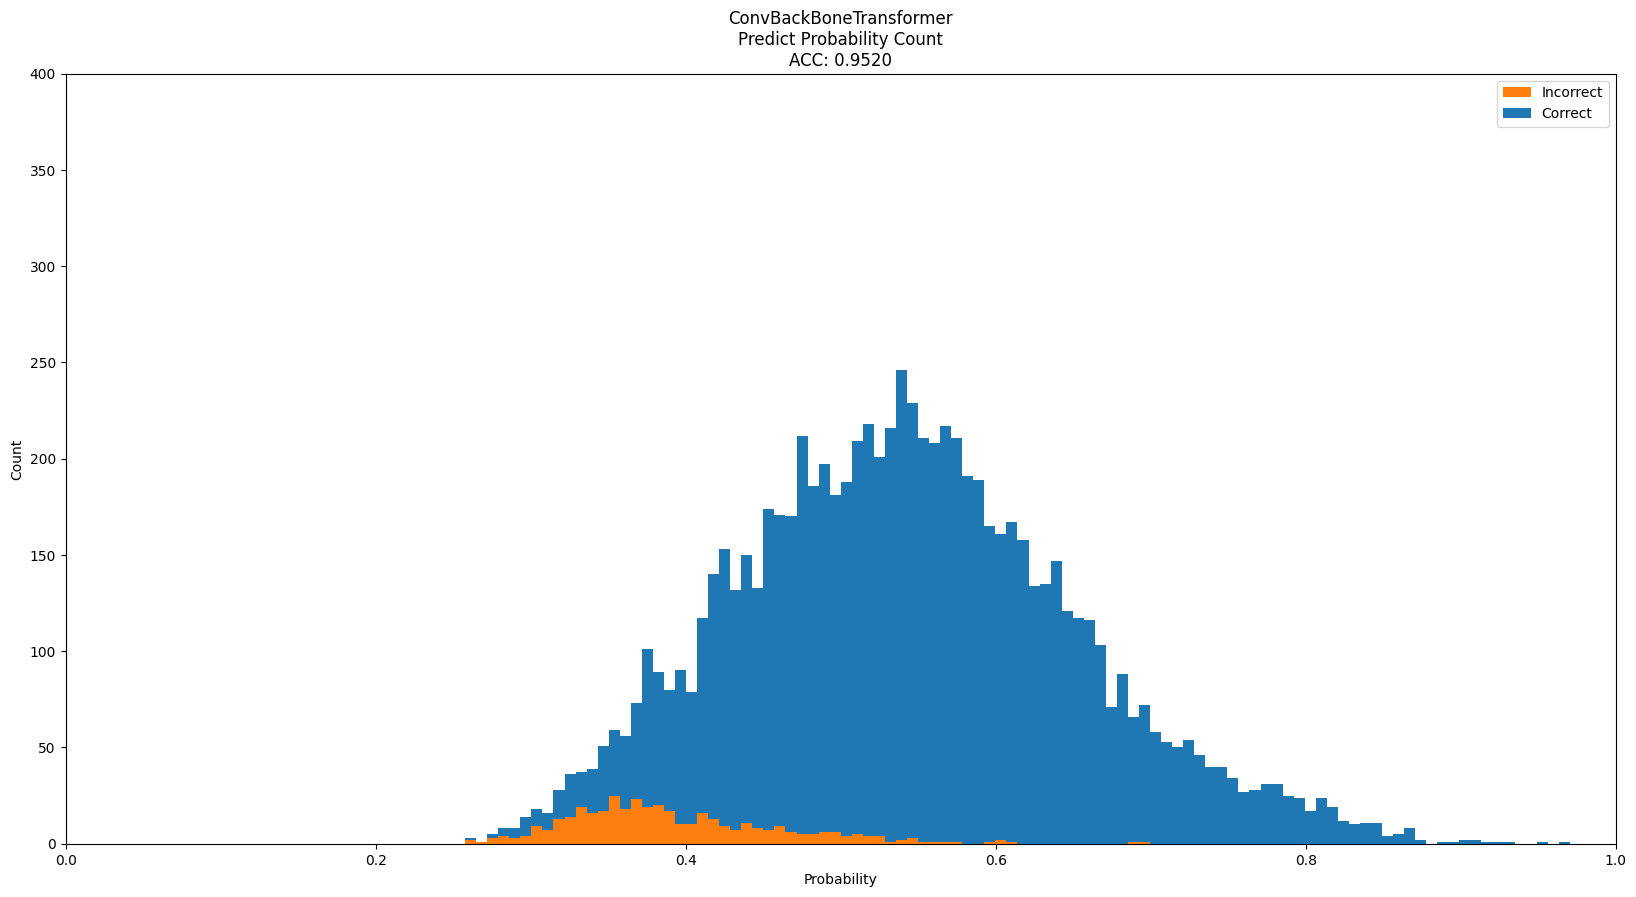

In [13]:
show_count(convbbt_df, 'ConvBackBoneTransformer')

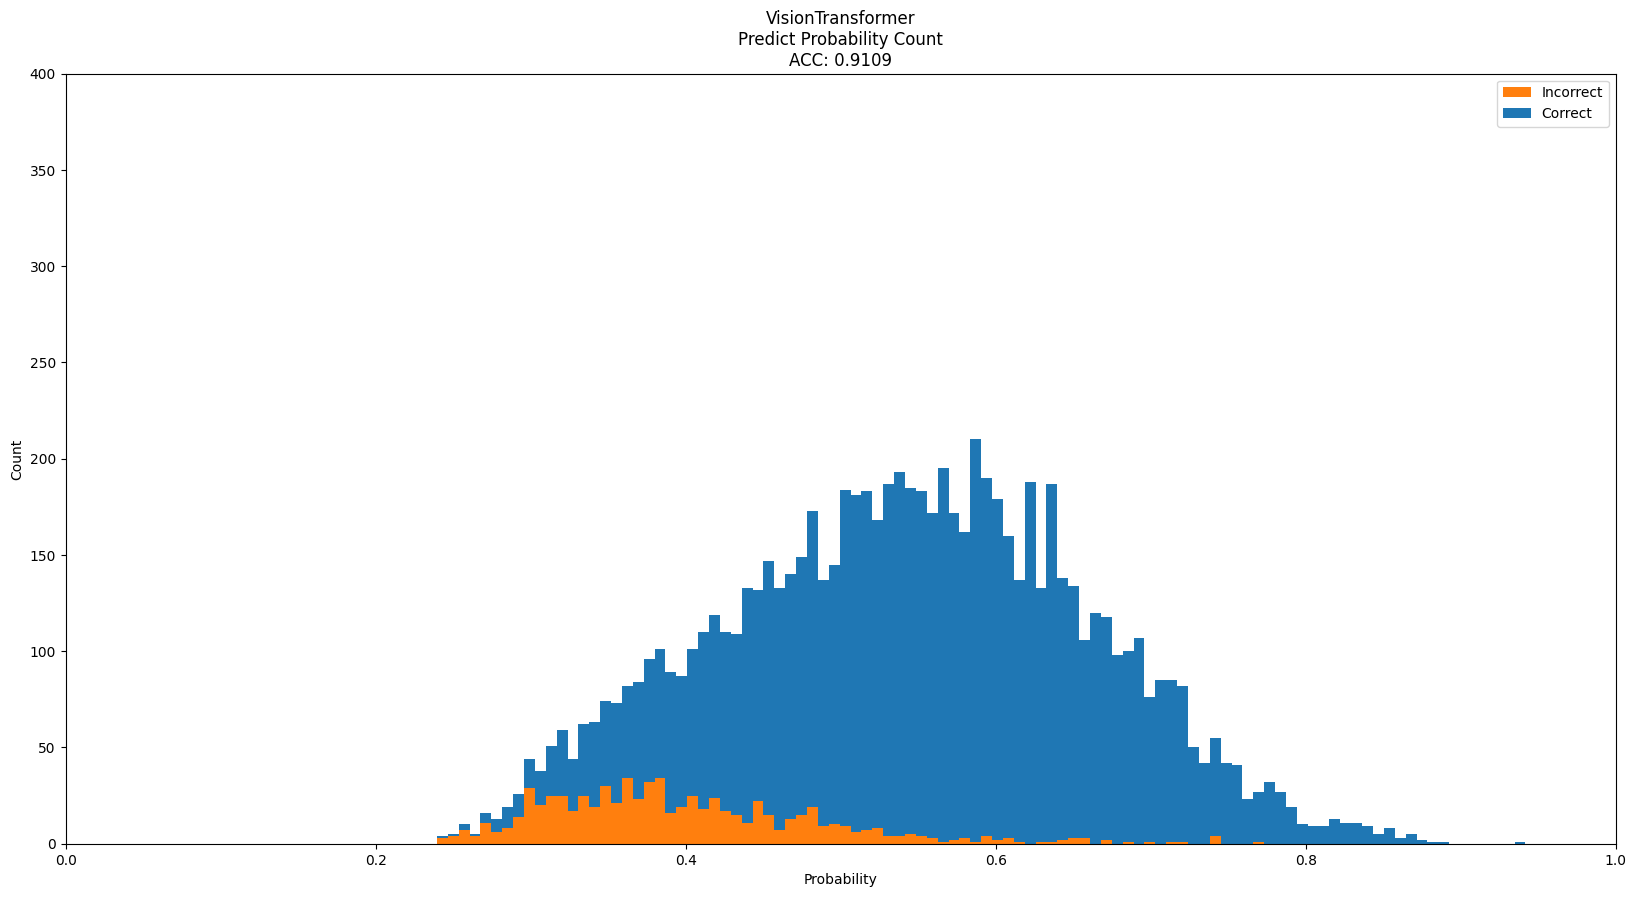

In [14]:
show_count(vit_df, 'VisionTransformer')

## Stacked Count

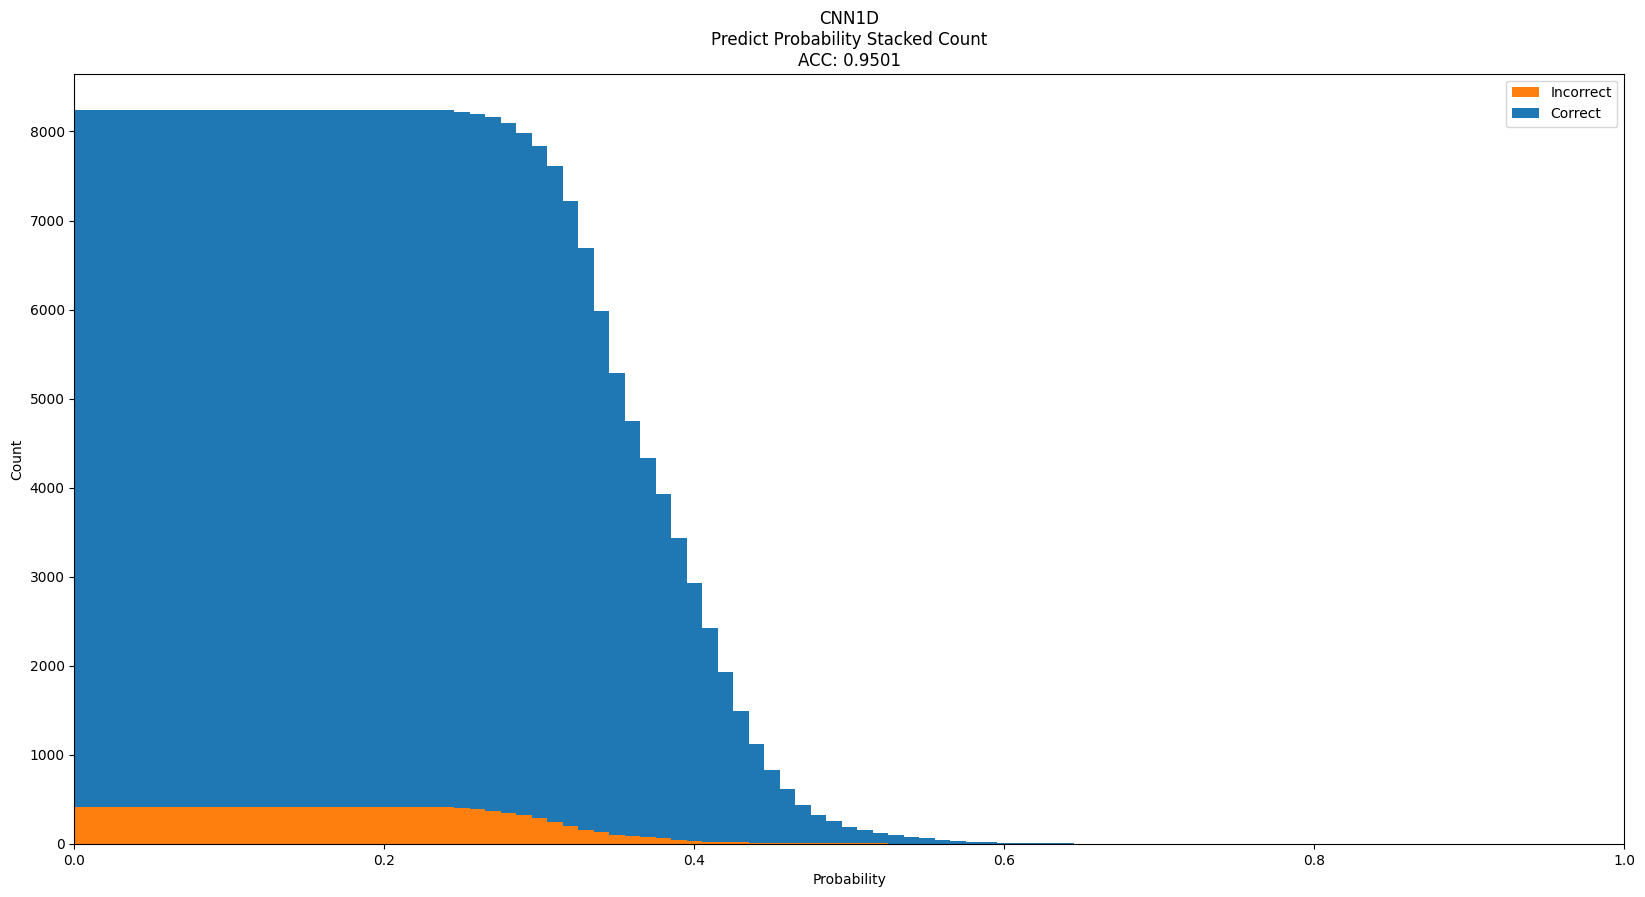

In [15]:
show_count_stacked(cnn1d_df, 'CNN1D')

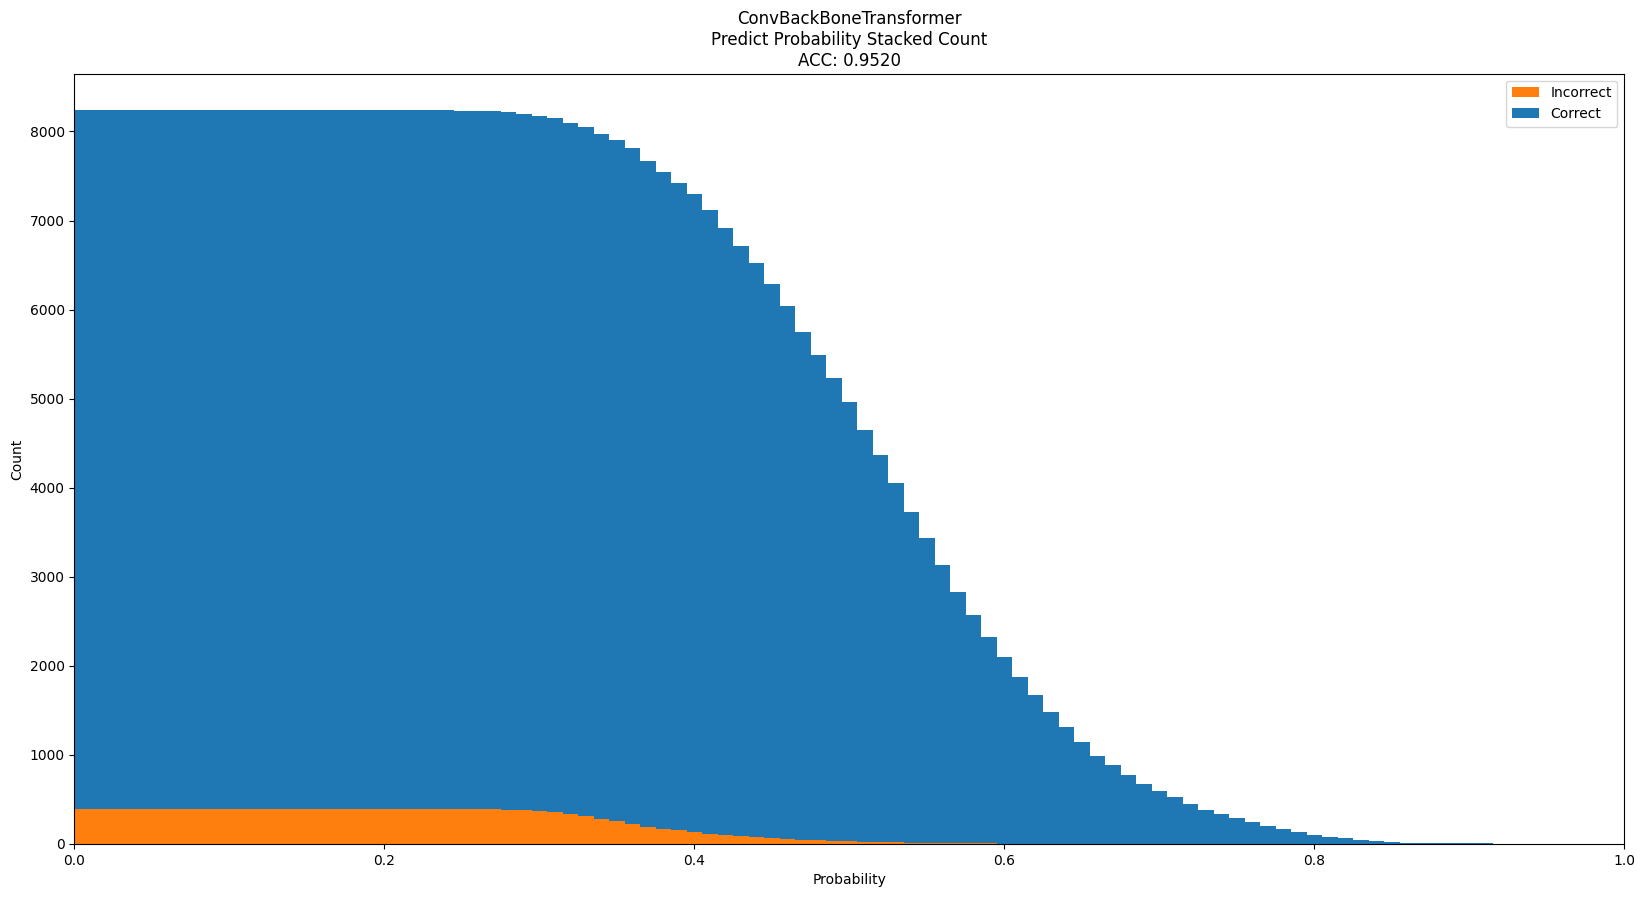

In [16]:
show_count_stacked(convbbt_df, 'ConvBackBoneTransformer')

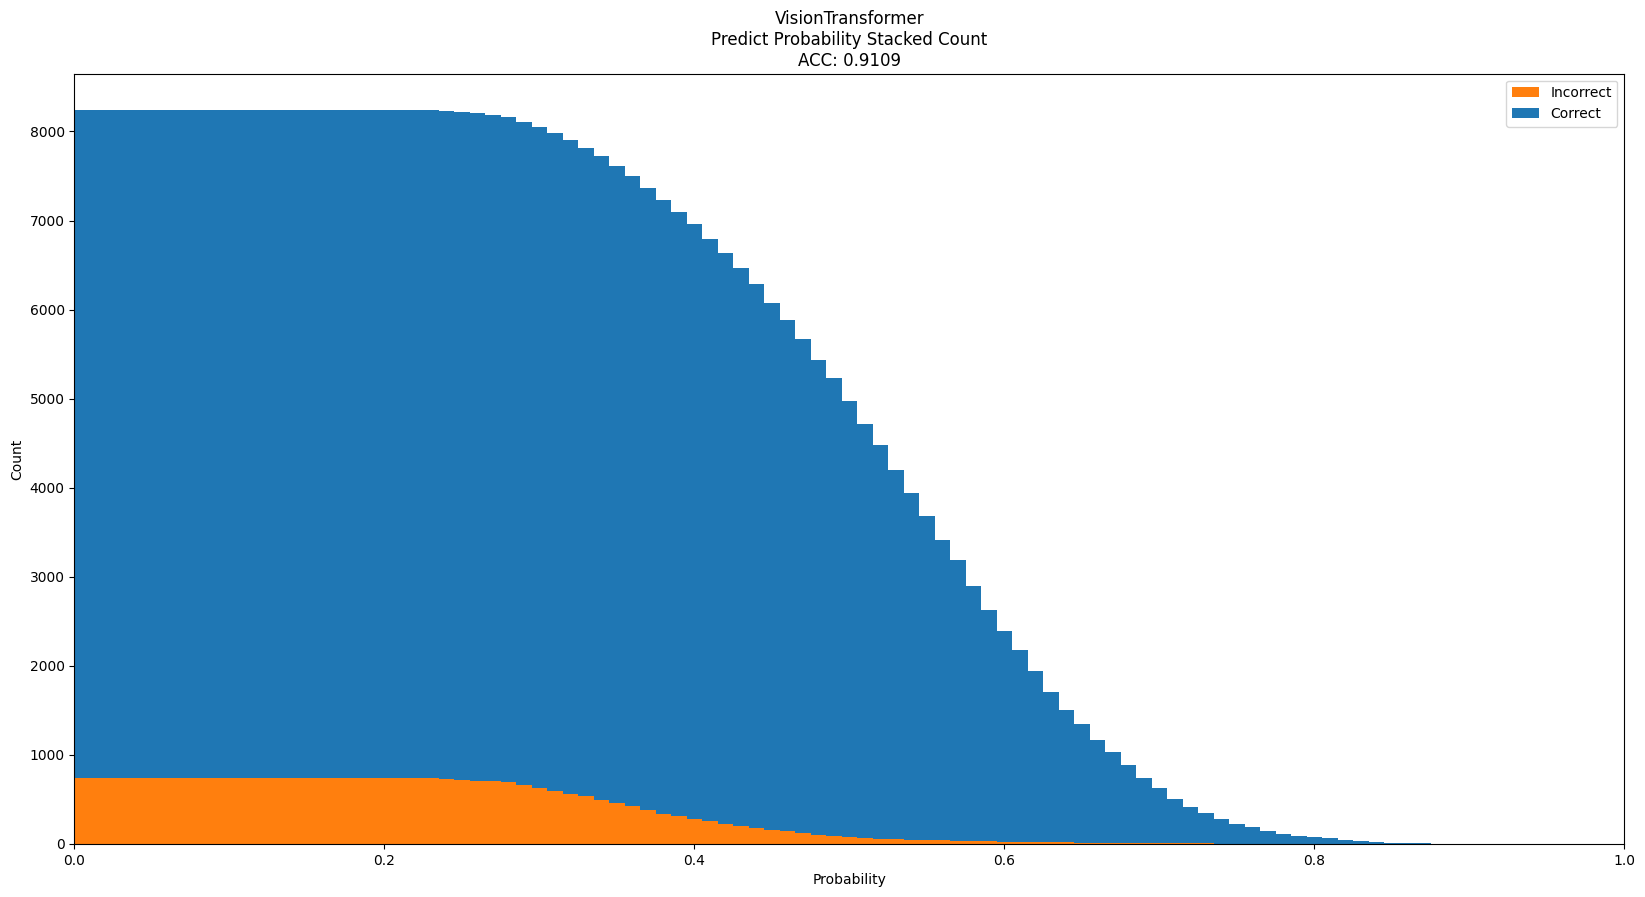

In [17]:
show_count_stacked(vit_df, 'VisionTransformer')

# Each Model's Result Analysis

In [18]:
cnn_correct_index = cnn1d_df.loc[cnn1d_df.true_label==cnn1d_df.predict_label].index
convbbt_correct_index = convbbt_df.loc[convbbt_df.true_label==convbbt_df.predict_label].index
vit_correct_index = vit_df.loc[vit_df.true_label==vit_df.predict_label].index

cnn_incorrect_index = cnn1d_df.loc[cnn1d_df.true_label!=cnn1d_df.predict_label].index
convbbt_incorrect_index = convbbt_df.loc[convbbt_df.true_label!=convbbt_df.predict_label].index
vit_incorrect_index = vit_df.loc[vit_df.true_label!=vit_df.predict_label].index

all_correct_index = list(set(cnn_correct_index)& set(convbbt_correct_index) & set(vit_correct_index))
all_incorrect_index = list(set(cnn_incorrect_index) & set(convbbt_incorrect_index) & set(vit_incorrect_index))

print(f'All index num: {len(cnn1d_df)}')
print(f'All correct index num: {len(all_correct_index)}')
print(f'All incorrect index num: {len(all_incorrect_index)}')
print(f'ideal accuracy: {1-len(all_incorrect_index)/len(cnn1d_df):.4f}')
print("-"*50 )
print("All incorrect index label count:")
cnn1d_df.loc[all_incorrect_index,"true_label"].value_counts()

All index num: 8237
All correct index num: 7151
All incorrect index num: 84
ideal accuracy: 0.9898
--------------------------------------------------
All incorrect index label count:


Upstairs      25
Downstairs    25
Walking       14
Jogging       11
Sitting        5
Standing       4
Name: true_label, dtype: int64

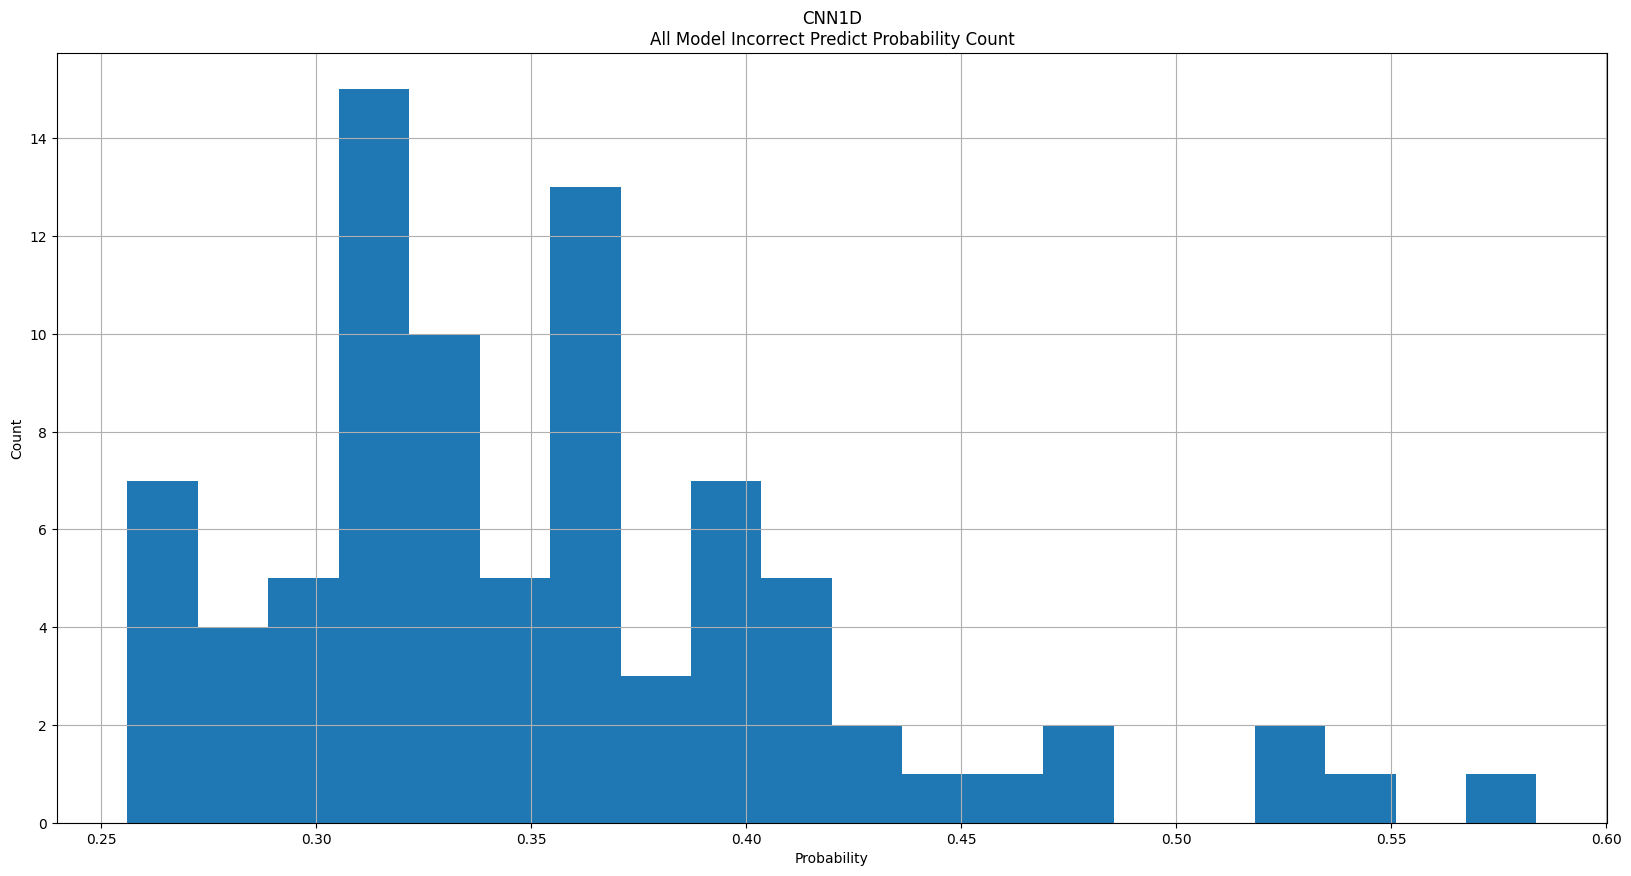

Upstairs      38
Downstairs    20
Jogging       15
Walking        9
Standing       2
Name: predict_label, dtype: int64

In [19]:
cnn1d_df.loc[all_incorrect_index,"predict_probability"].hist(bins=20)
plt.title('CNN1D\nAll Model Incorrect Predict Probability Count')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()
cnn1d_df.loc[all_incorrect_index,"predict_label"].value_counts()

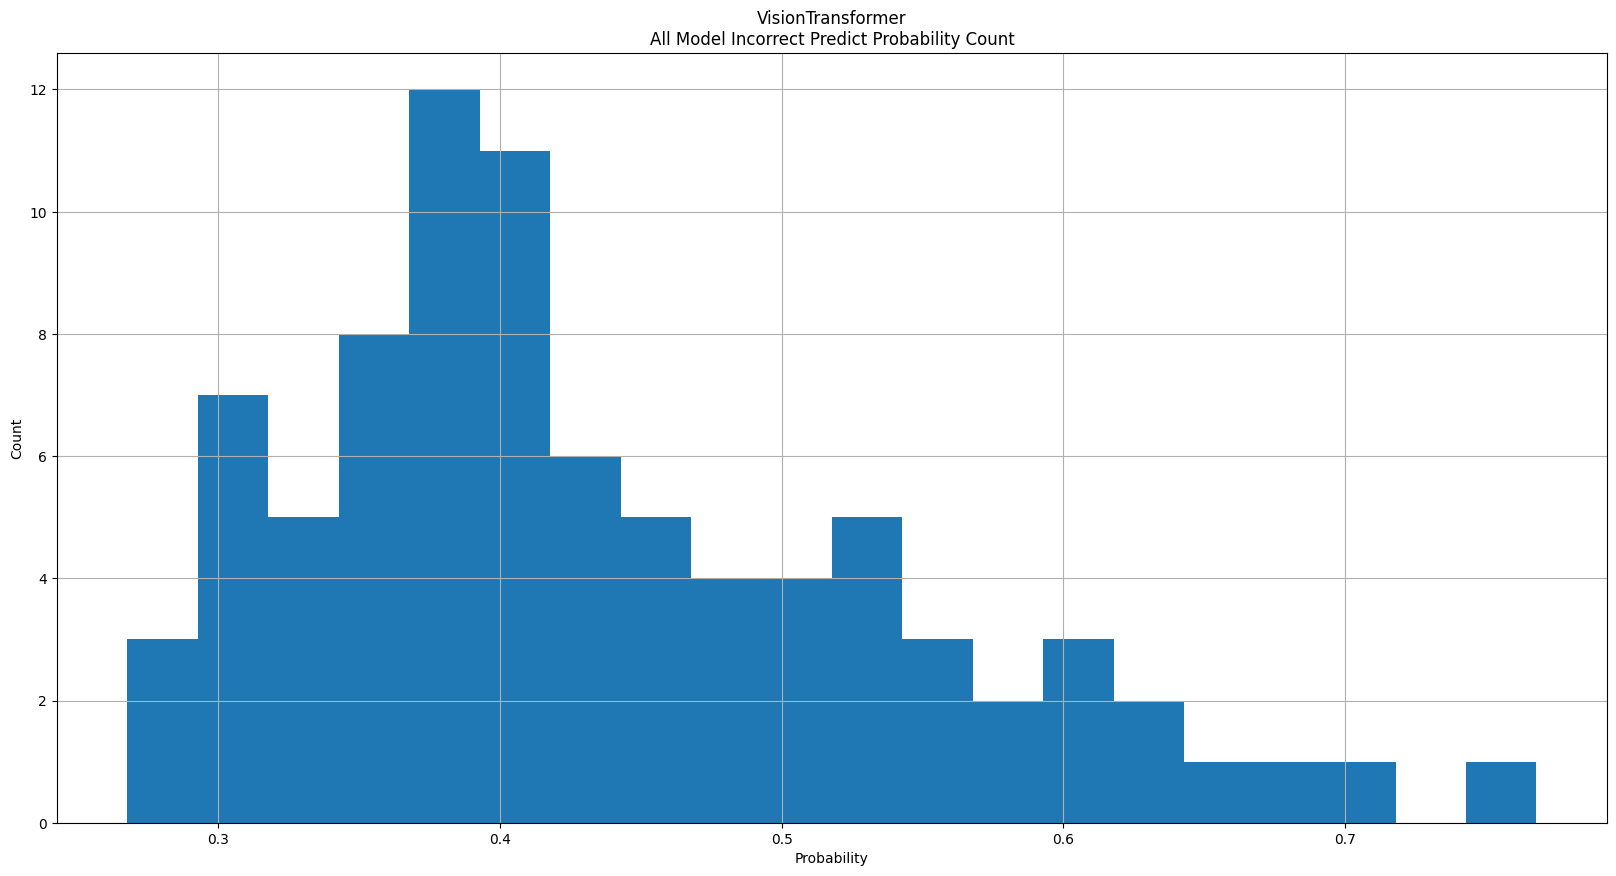

Upstairs      33
Downstairs    20
Jogging       18
Walking       10
Standing       3
Name: predict_label, dtype: int64

In [20]:
vit_df.loc[all_incorrect_index,"predict_probability"].hist(bins=20)
plt.title('VisionTransformer\nAll Model Incorrect Predict Probability Count')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()
vit_df.loc[all_incorrect_index,"predict_label"].value_counts()

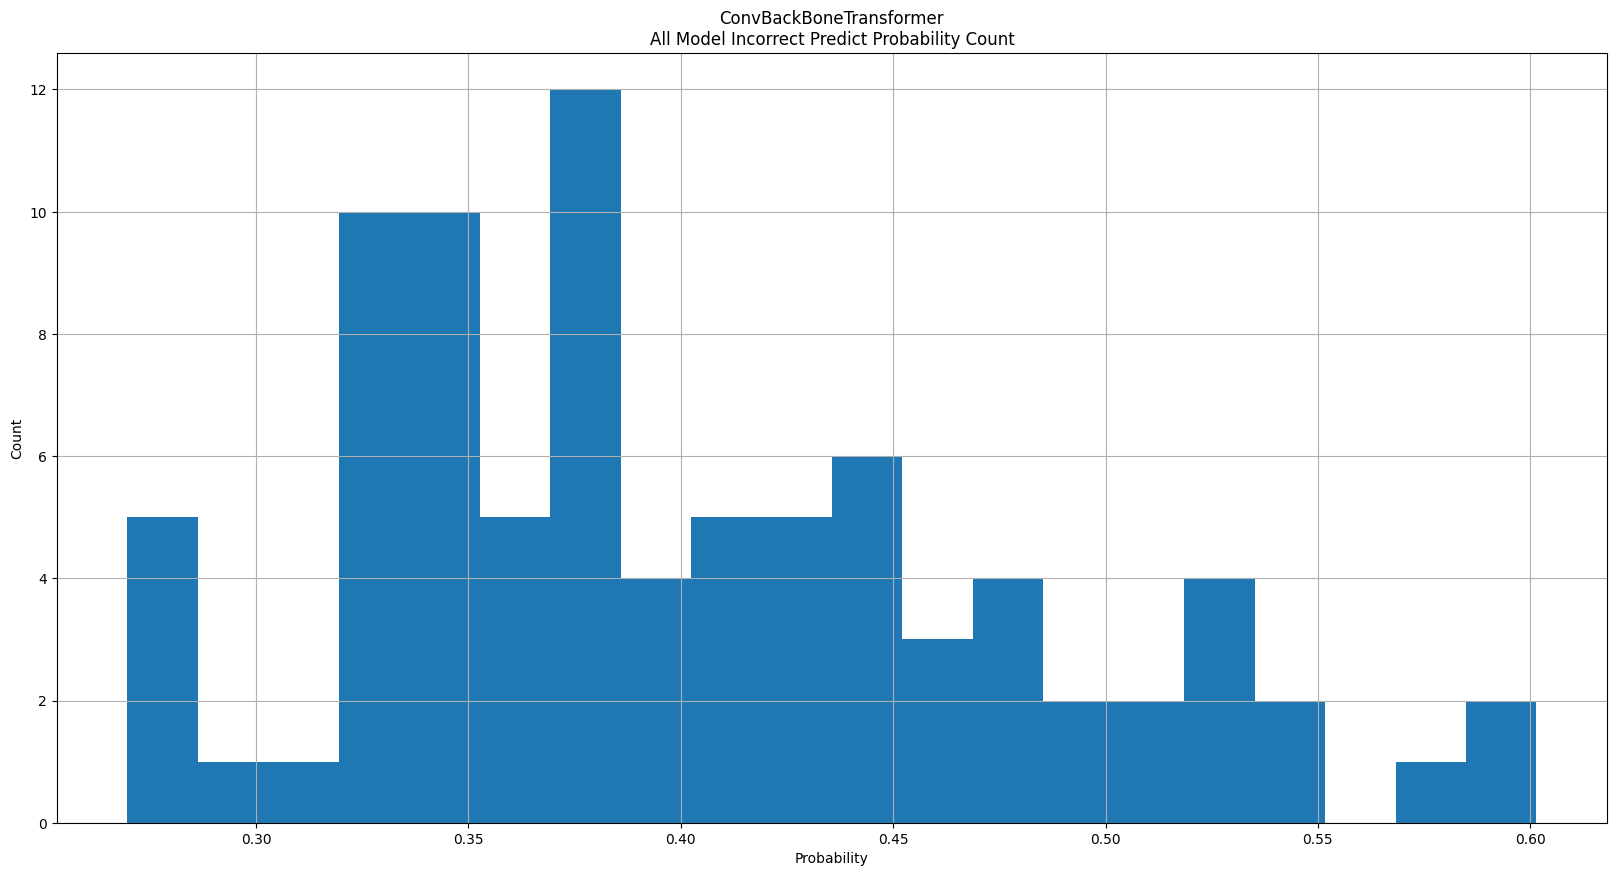

Upstairs      37
Downstairs    21
Walking       13
Jogging       12
Standing       1
Name: predict_label, dtype: int64

In [21]:
convbbt_df.loc[all_incorrect_index,"predict_probability"].hist(bins=20)
plt.title('ConvBackBoneTransformer\nAll Model Incorrect Predict Probability Count')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()
convbbt_df.loc[all_incorrect_index,"predict_label"].value_counts()

# Ensamble Model

## 1. Sum of Probabilities Ensamble

In [22]:
ensamble1_name = 'Sum-of-Probability-Ensamble'

In [23]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
ensamble1_df = cnn1d_df.loc[:, LABELS].copy() + convbbt_df.loc[:, LABELS].copy() + vit_df.loc[:, LABELS].copy()
ensamble1_df = ensamble1_df.apply(lambda x: x / x.sum(), axis=1)
ensamble1_df["predict_probability"] = ensamble1_df.max(axis=1)
ensamble1_df["predict_label"] = ensamble1_df.idxmax(axis=1)
ensamble1_df['true_label'] = true_label.map(lambda x: LABELS[x])

In [24]:
ensamble1_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.173604,0.098091,0.020696,0.020889,0.290626,0.396092,0.396092,Walking,Walking
1,0.106734,0.000000,0.471726,0.249582,0.108694,0.063264,0.471726,Sitting,Sitting
2,0.203734,0.025199,0.032336,0.061434,0.426114,0.251183,0.426114,Upstairs,Upstairs
3,0.208659,0.478604,0.009040,0.038533,0.157645,0.107519,0.478604,Jogging,Jogging
4,0.116889,0.027867,0.176307,0.555738,0.095048,0.028151,0.555738,Standing,Standing


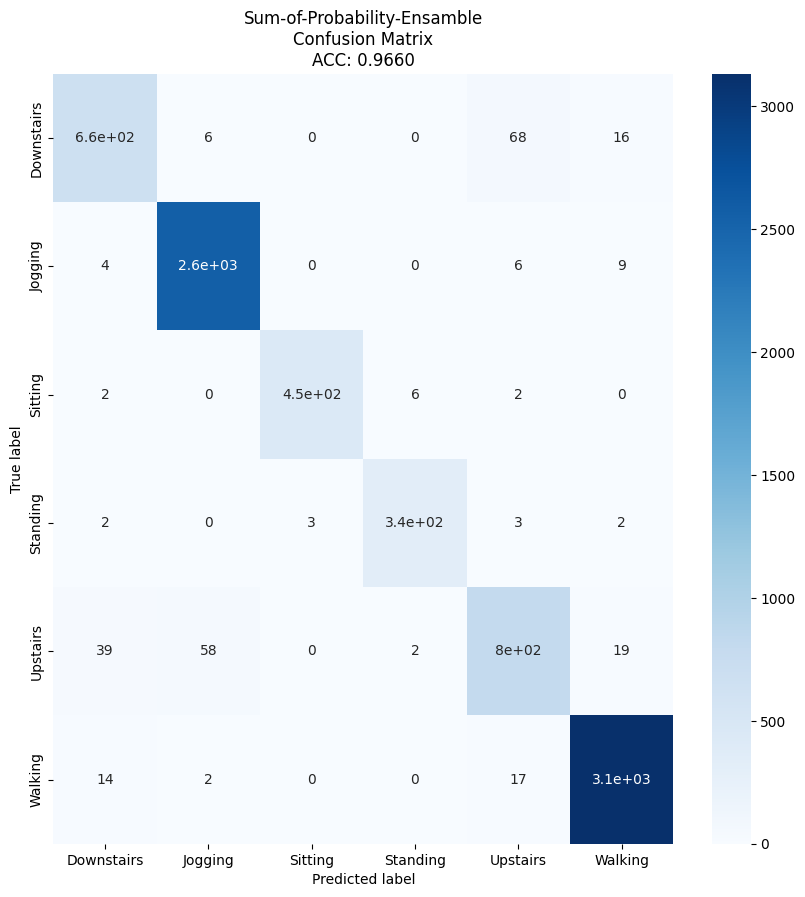

In [25]:
show_confusion_matrix(ensamble1_df, ensamble1_name)

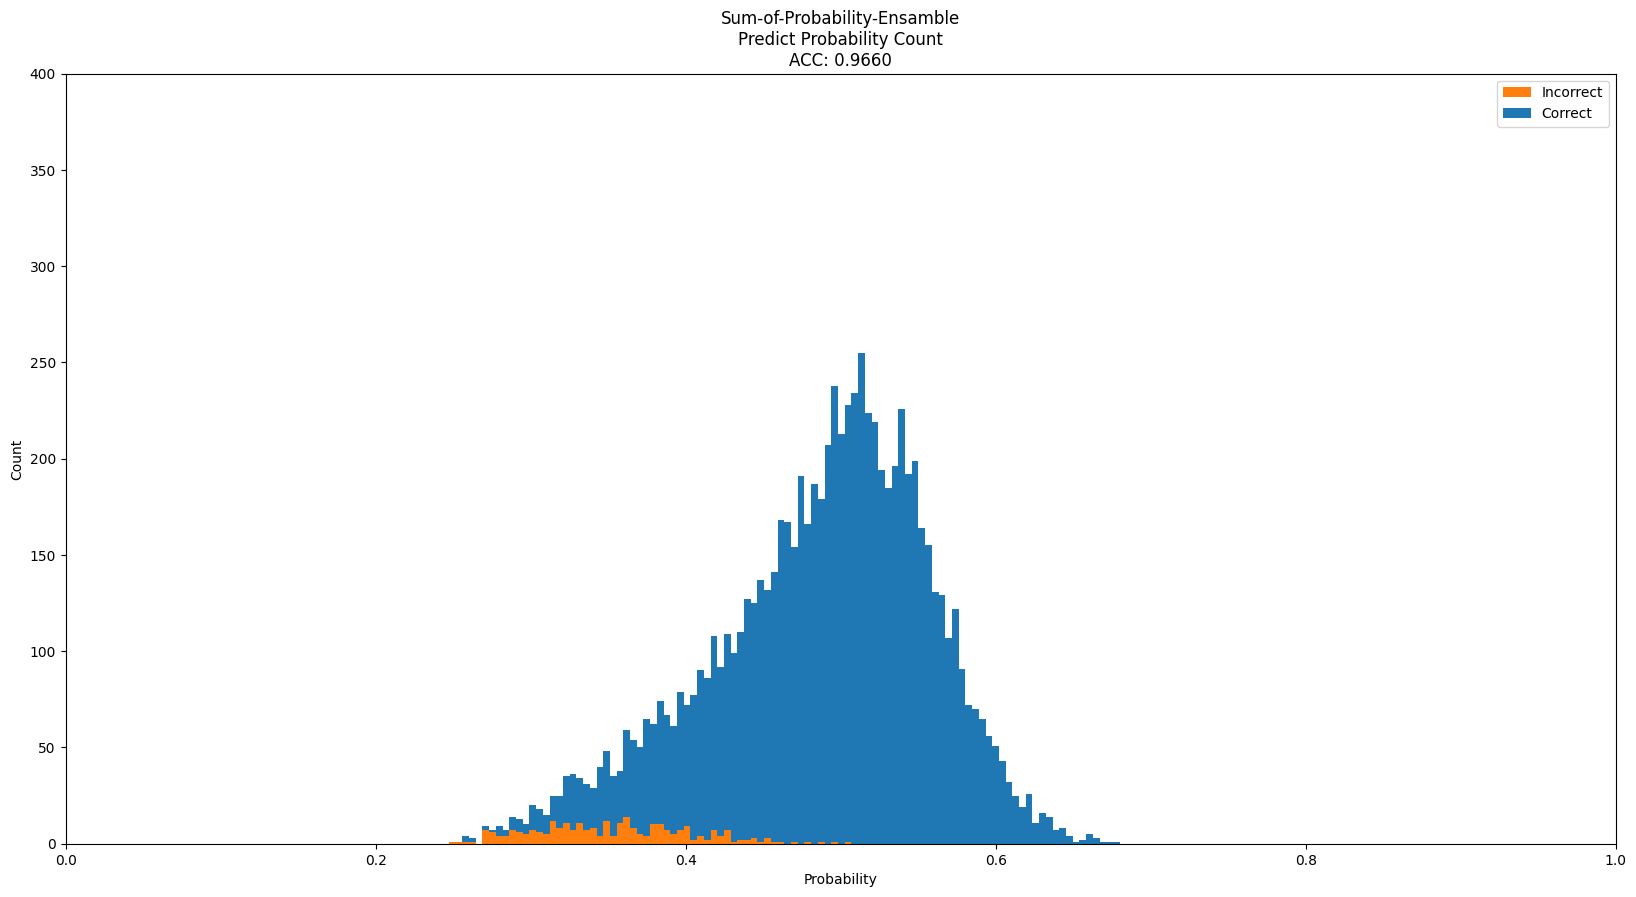

In [26]:
show_count(ensamble1_df, ensamble1_name)

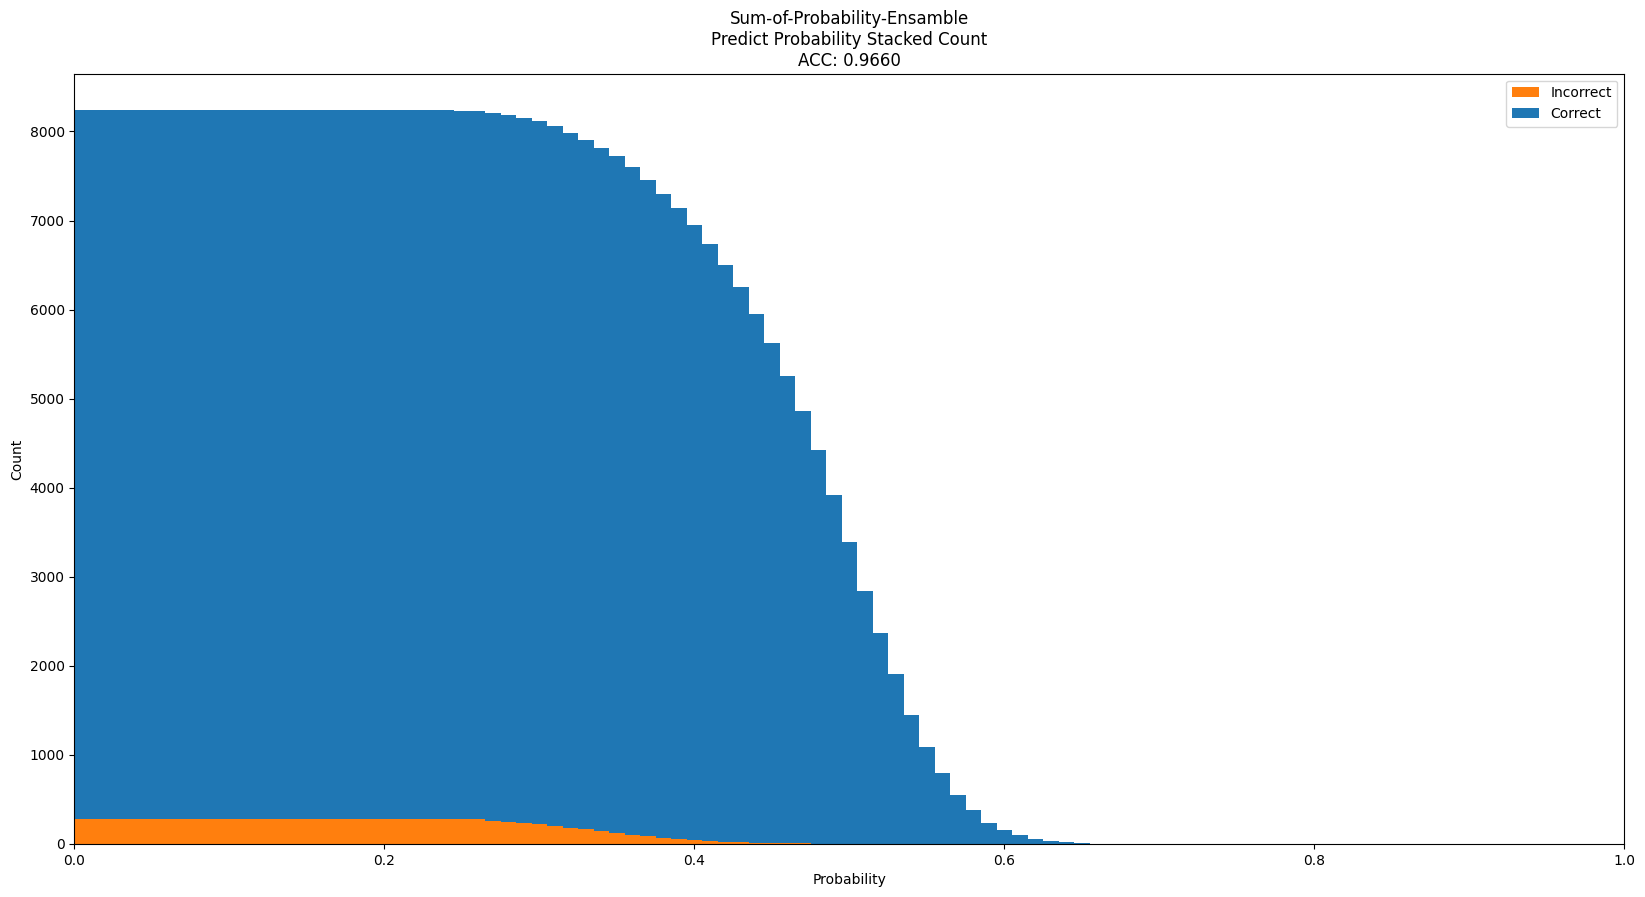

In [27]:
show_count_stacked(ensamble1_df, ensamble1_name)

In [28]:
print(f'Accuracy: {calc_accuracy(ensamble1_df):.4f}')
print(f'incorrect index num: {len(ensamble1_df.loc[ensamble1_df.true_label!=ensamble1_df.predict_label])}')
print("-"*50)
ensamble1_df.loc[ensamble1_df.predict_label!=ensamble1_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9660
incorrect index num: 280
--------------------------------------------------


Upstairs      96
Jogging       66
Downstairs    61
Walking       46
Standing       8
Sitting        3
Name: predict_label, dtype: int64

In [29]:
calc_thredshold_df(ensamble1_df)

/tmp/ipykernel_27309/1207289548.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.966007,8237
0.1,0.966007,8237
0.2,0.966007,8237
0.3,0.971068,8157
0.4,0.992996,7139
0.5,0.999745,3916
0.6,1.000000,238
0.7,NaN,0
0.8,NaN,0


## 2. Vote Ensamble

In [30]:
ensamble2_name = 'Vote-Ensamble'

In [31]:
modelnames = ["CNN1D", "ConvBackBoneTransformer", "VisionTransformer"]
ensamble2_label_df = pd.concat([cnn1d_df.loc[:, "predict_label"].copy(), convbbt_df.loc[:, "predict_label"].copy(), vit_df.loc[:, "predict_label"].copy()], axis=1)
ensamble2_probability_df= pd.concat([cnn1d_df.loc[:, "predict_probability"].copy(), convbbt_df.loc[:, "predict_probability"].copy(), vit_df.loc[:, "predict_probability"].copy()], axis=1)
ensamble2_label_df.columns = modelnames
ensamble2_probability_df.columns = modelnames
ensamble2_df = pd.DataFrame({
                        "predict_label": ensamble2_label_df.apply(lambda x: x.value_counts().idxmax(), axis=1),
                        "predict_probability": ensamble2_probability_df.max(axis=1),
                        "true_label": true_label.map(lambda x: LABELS[x]), "predict_probability": ensamble2_probability_df.max(axis=1),
                        })

In [32]:
ensamble2_df.head()

,predict_label,predict_probability,true_label
0,Walking,0.442952,Walking
1,Sitting,0.494851,Sitting
2,Upstairs,0.496654,Upstairs
3,Jogging,0.574988,Jogging
4,Standing,0.643581,Standing


In [33]:
value_counts = ensamble2_label_df.apply(lambda x: x.value_counts(), axis=1)

vote_3_index = value_counts.loc[(value_counts == 3).apply(lambda x: any(x), axis=1),:].index
vote_2_index = value_counts.loc[(value_counts == 2).apply(lambda x: any(x), axis=1),:].index
vote_1_index = list(set(value_counts.loc[(value_counts == 1).apply(lambda x: any(x), axis=1),:].index) - set(vote_2_index))

vote_3 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_3_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_3_index].map(lambda x: LABELS[x])
                })
vote_2 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_2_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_2_index].map(lambda x: LABELS[x])
                })
vote_1 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_1_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_1_index].map(lambda x: LABELS[x])
                })

In [34]:
print('All num: ', len(ensamble2_label_df))
print(f'Vote 3 num: {len(vote_3)}') 
print(f'Vote 2 num: {len(vote_2)}')
print(f'Vote 1 num: {len(vote_1)}')

All num:  8237
Vote 3 num: 7197
Vote 2 num: 956
Vote 1 num: 84


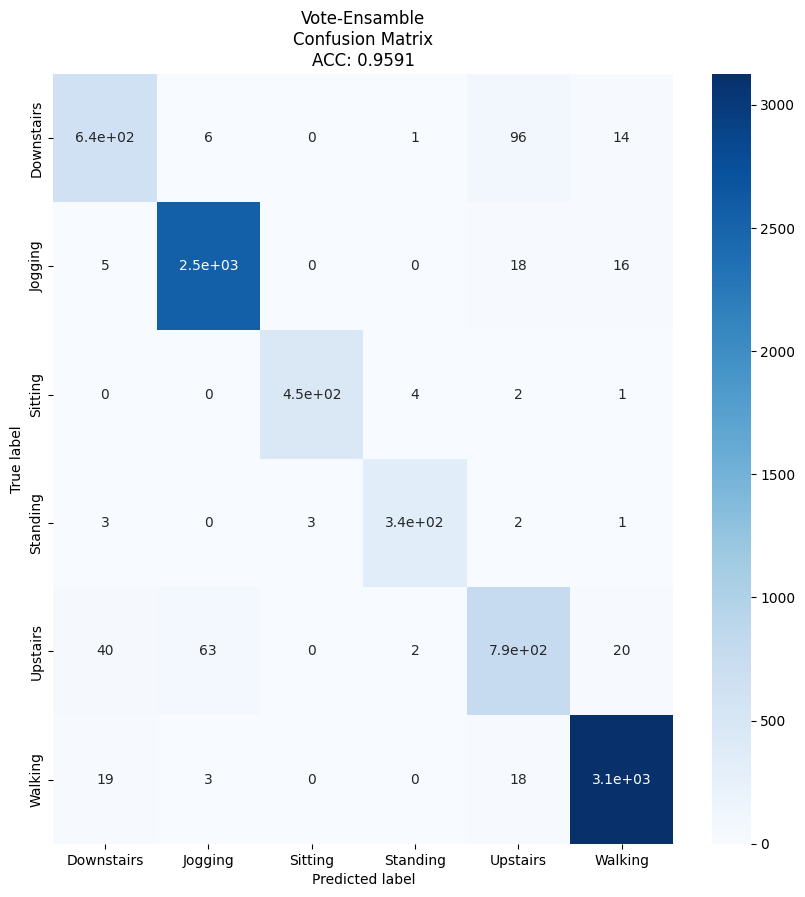

In [35]:
show_confusion_matrix(ensamble2_df, ensamble2_name)

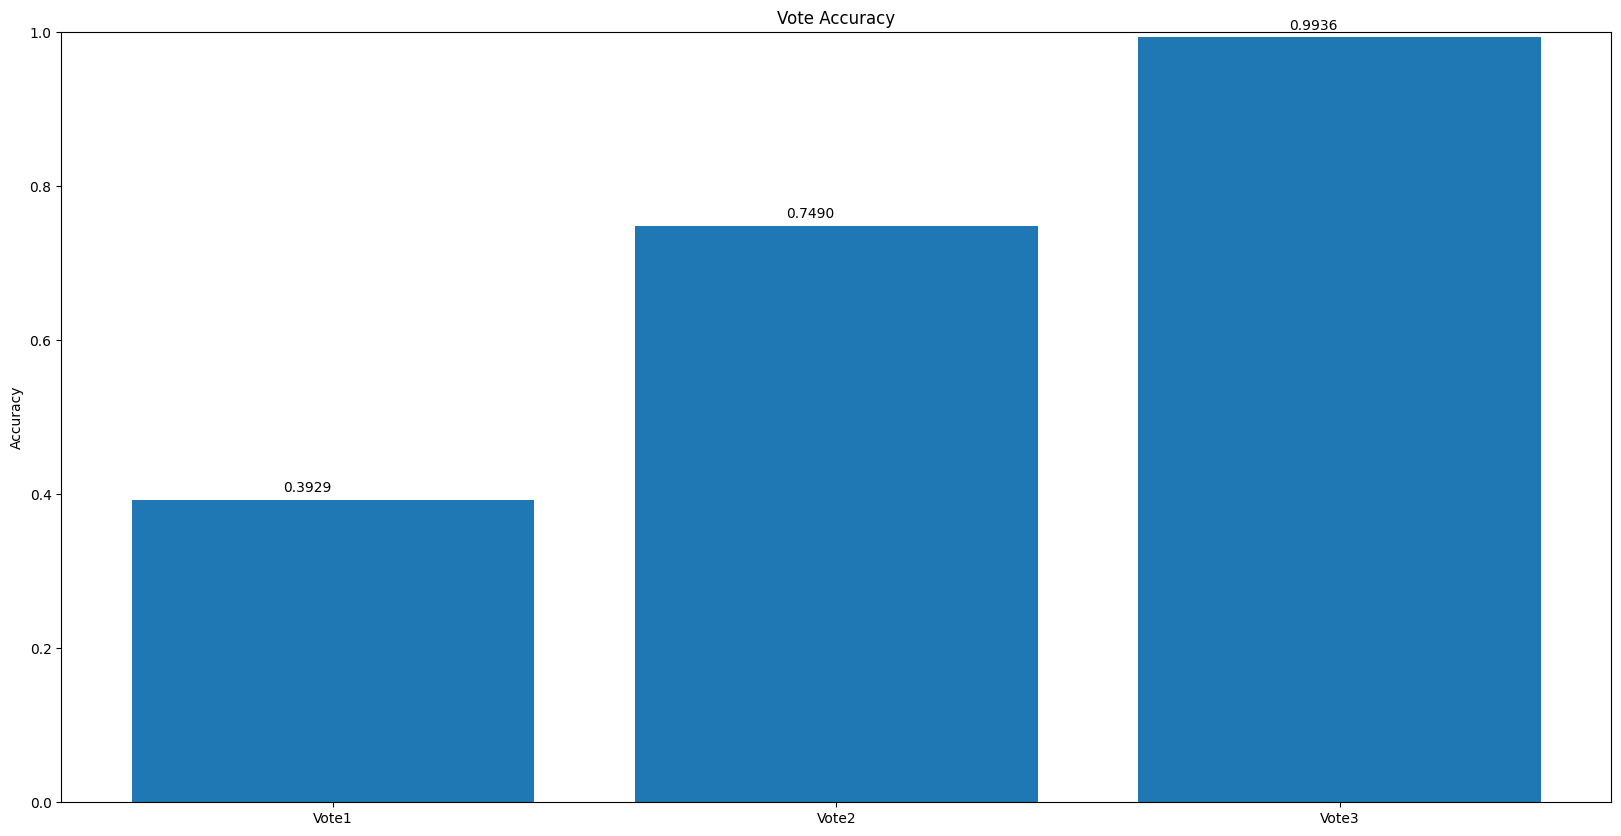

In [36]:
vote1_acc = calc_accuracy(vote_1)
vote2_acc = calc_accuracy(vote_2)
vote3_acc = calc_accuracy(vote_3)
plt.bar(["Vote1", "Vote2", "Vote3"], [vote1_acc, vote2_acc, vote3_acc])
plt.text(-0.1, vote1_acc+0.01, f'{vote1_acc:.4f}')
plt.text(0.9, vote2_acc+0.01, f'{vote2_acc:.4f}')
plt.text(1.9, vote3_acc+0.01, f'{vote3_acc:.4f}')
plt.title('Vote Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(f'assets/{ensamble2_name}-accuracy.png')
plt.show()

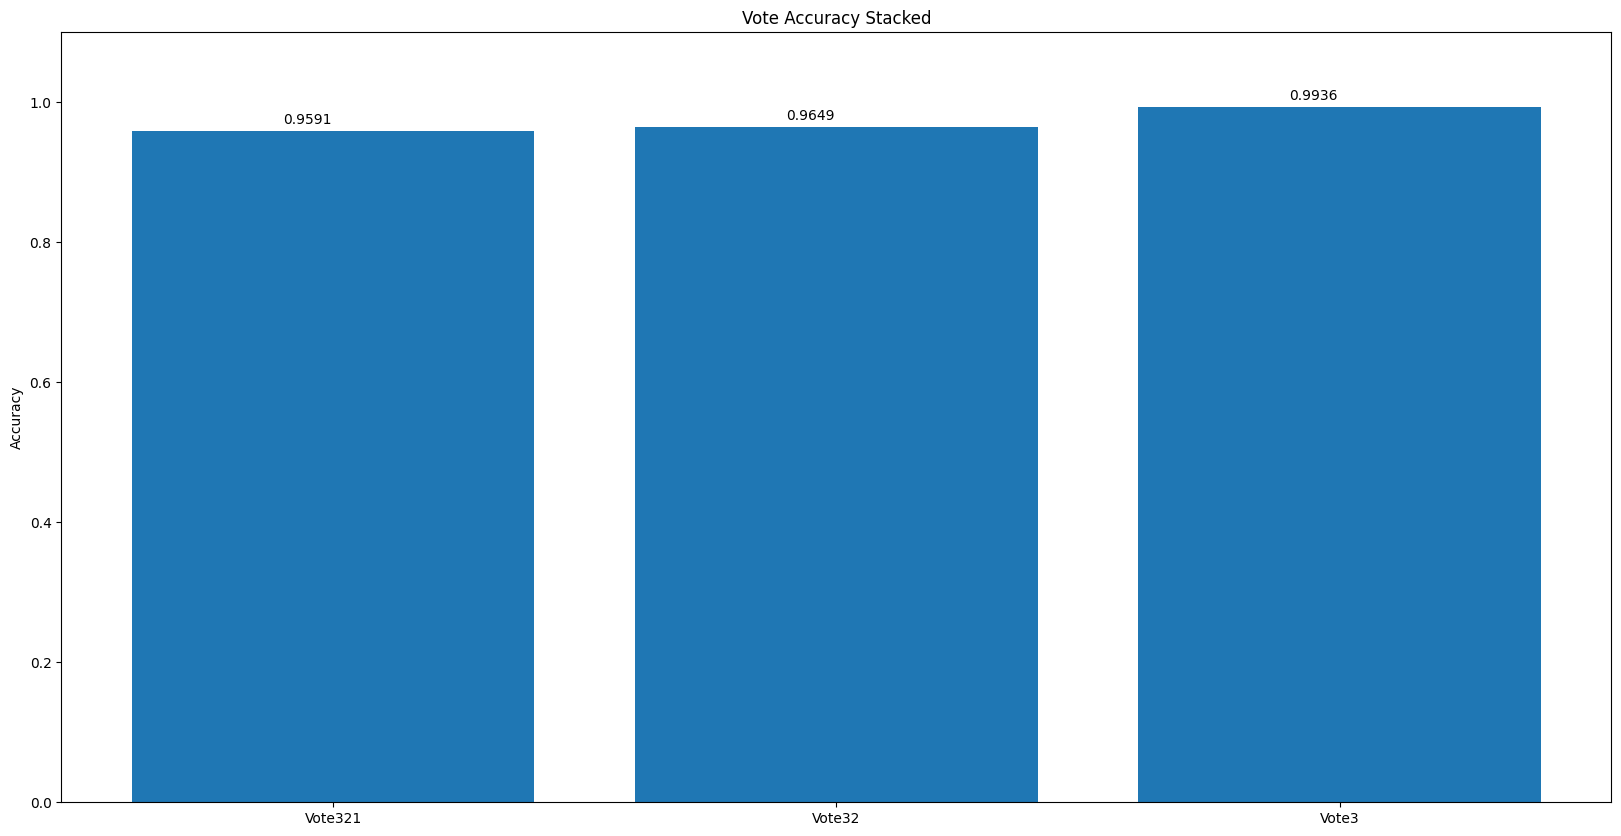

In [37]:
vote_321 = pd.concat([vote_3, vote_2, vote_1], axis=0).reset_index()
vote_32 = pd.concat([vote_3, vote_2], axis=0).reset_index()

vote_321_acc = calc_accuracy(vote_321)
vote_32_acc = calc_accuracy(vote_32)
plt.bar(["Vote321", "Vote32", "Vote3"], [vote_321_acc, vote_32_acc, vote3_acc])
plt.text(-0.1, vote_321_acc+0.01, f'{vote_321_acc:.4f}')
plt.text(0.9, vote_32_acc+0.01, f'{vote_32_acc:.4f}')
plt.text(1.9, vote3_acc+0.01, f'{vote3_acc:.4f}')
plt.title('Vote Accuracy Stacked')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.savefig(f'assets/{ensamble2_name}-accuracy-stacked.png')
plt.show()


In [38]:
print(f'Accuracy: {calc_accuracy(ensamble2_df):.4f}')
print(f'incorrect index num: {len(ensamble2_df.loc[ensamble2_df.true_label!=ensamble2_df.predict_label])}')
print("-"*50)
ensamble2_df.loc[ensamble2_df.predict_label!=ensamble2_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9591
incorrect index num: 337
--------------------------------------------------


Upstairs      136
Jogging        72
Downstairs     67
Walking        52
Standing        7
Sitting         3
Name: predict_label, dtype: int64

## 3. Max of Probability Ensamble

In [39]:
ensamble3_name = 'Max-of-Probability-Ensamble'

In [40]:
modelnames = ["CNN1D", "ConvBackBoneTransformer", "VisionTransformer"]
ensamble3_label_df = pd.concat([cnn1d_df.loc[:, "predict_label"].copy(), convbbt_df.loc[:, "predict_label"].copy(), vit_df.loc[:, "predict_label"].copy()], axis=1)
ensamble3_probability_df= pd.concat([cnn1d_df.loc[:, "predict_probability"].copy(), convbbt_df.loc[:, "predict_probability"].copy(), vit_df.loc[:, "predict_probability"].copy()], axis=1)
ensamble3_label_df.columns = modelnames
ensamble3_probability_df.columns = modelnames
ensamble3_df = pd.DataFrame({
                        "predict_label": ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1),
                        "predict_probability": ensamble3_probability_df.max(axis=1),
                        "predict_from": ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1),
                        "true_label": true_label.map(lambda x: LABELS[x]),
                        })
refcol = ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1)
for i in range(len(ensamble3_probability_df)):
    ensamble3_df.loc[i,"predict_label"] = ensamble3_label_df.loc[i, refcol.iloc[i]]

In [41]:
ensamble3_df.head()

,predict_label,predict_probability,predict_from,true_label
0,Walking,0.442952,CNN1D,Walking
1,Sitting,0.494851,VisionTransformer,Sitting
2,Upstairs,0.496654,VisionTransformer,Upstairs
3,Jogging,0.574988,ConvBackBoneTransformer,Jogging
4,Standing,0.643581,ConvBackBoneTransformer,Standing


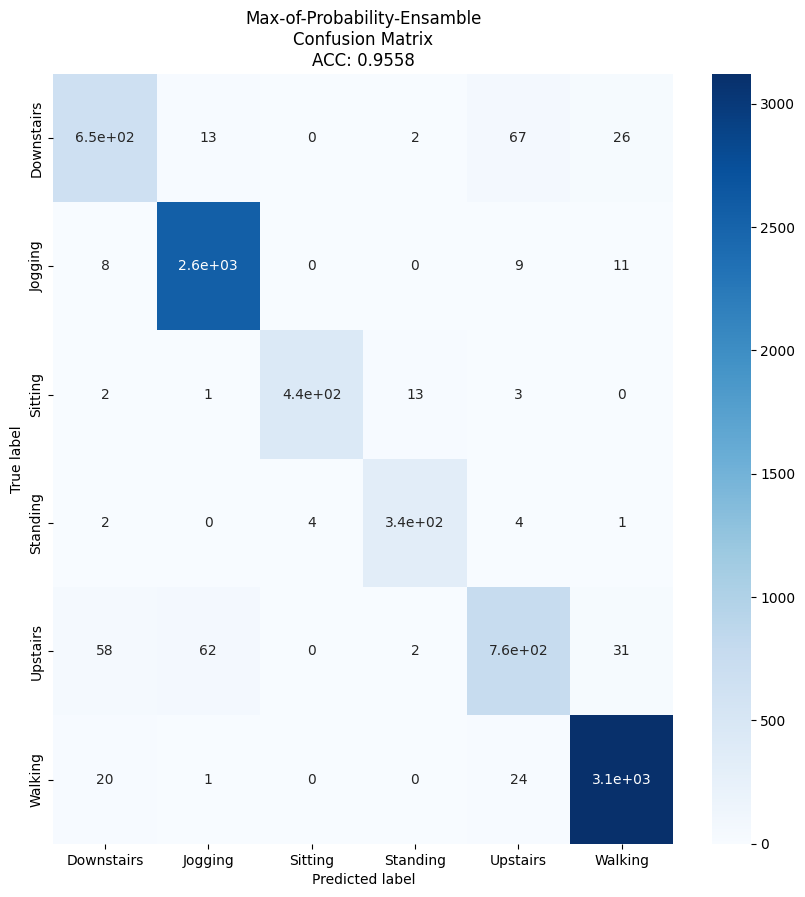

In [42]:
show_confusion_matrix(ensamble3_df, ensamble3_name)

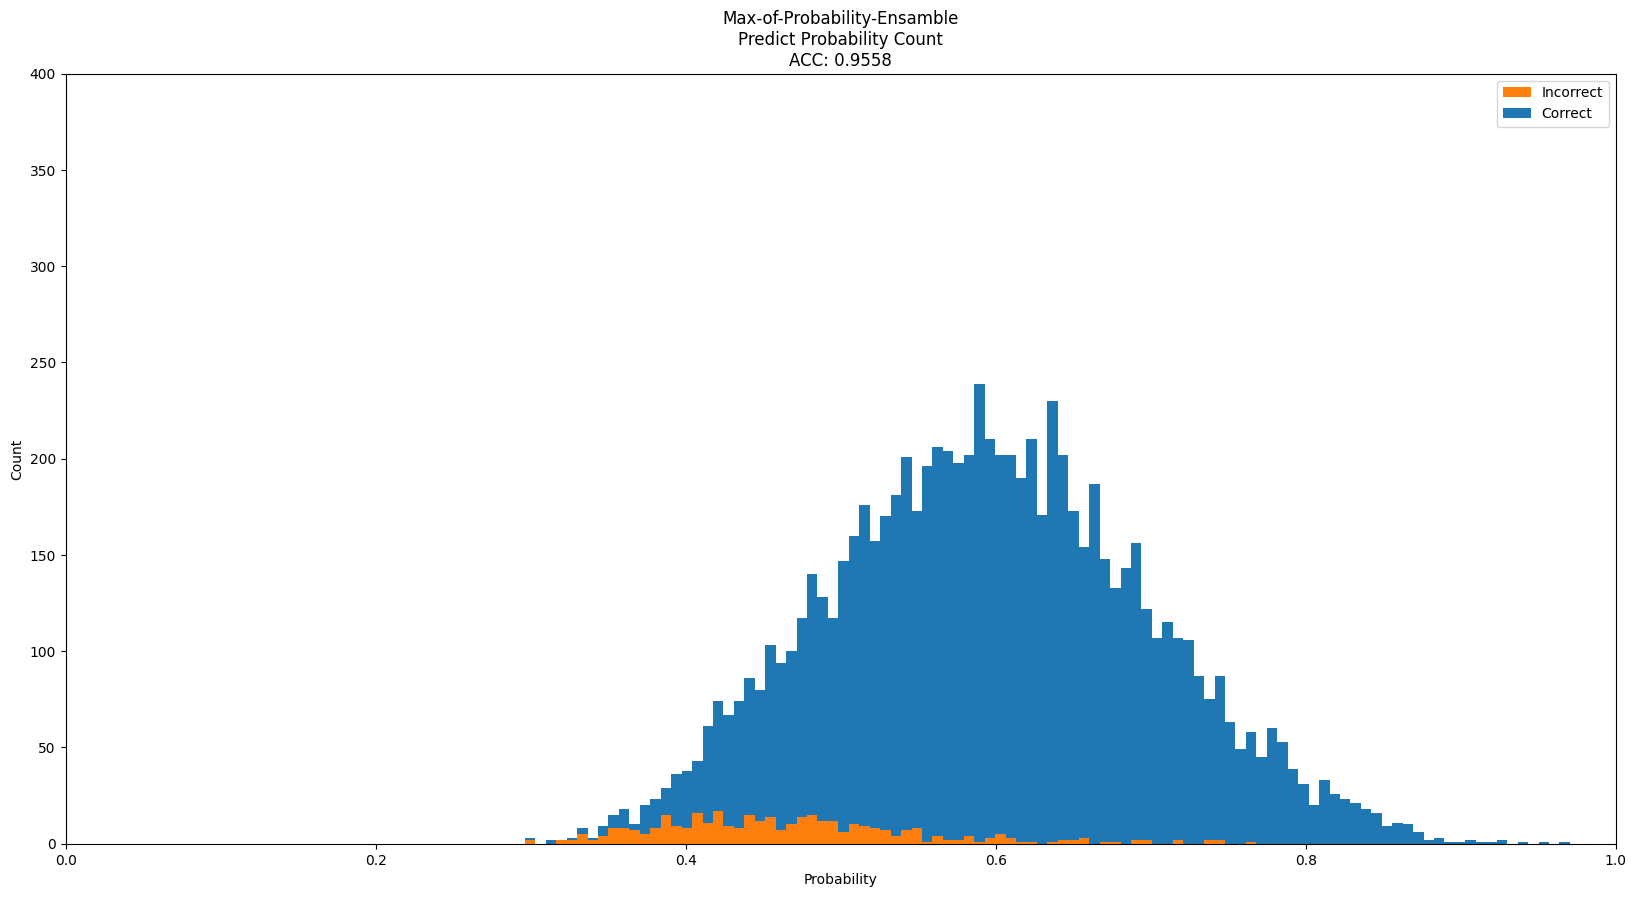

In [43]:
show_count(ensamble3_df, ensamble3_name)

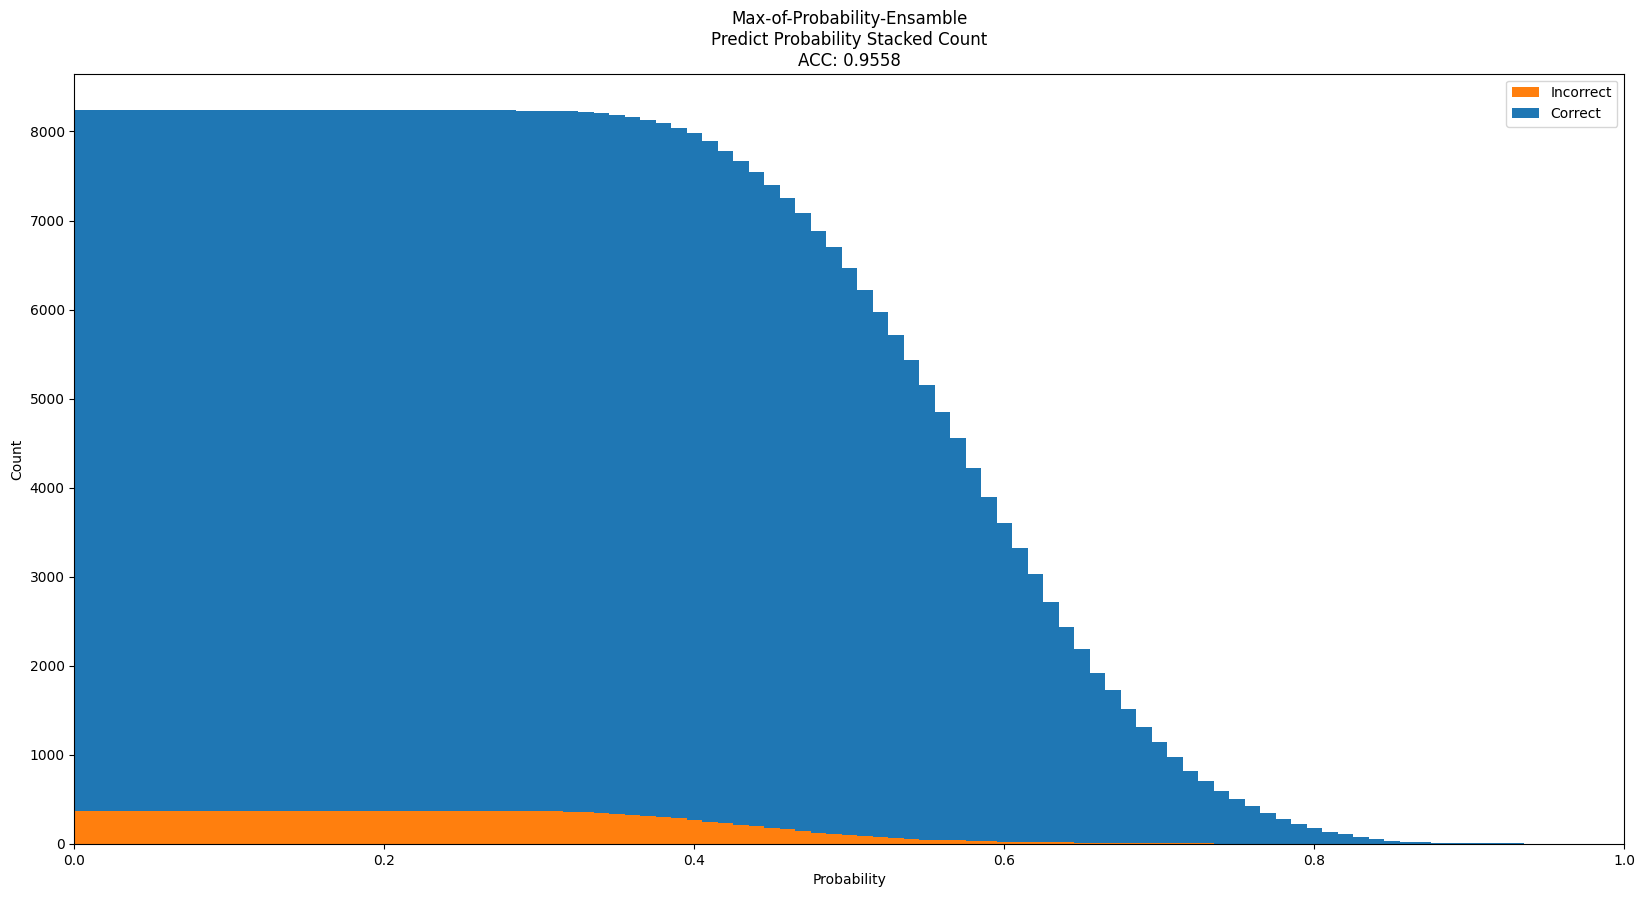

In [44]:
show_count_stacked(ensamble3_df, ensamble3_name)

In [45]:
print(f'Accuracy: {calc_accuracy(ensamble3_df):.4f}')
print(f'incorrect index num: {len(ensamble3_df.loc[ensamble3_df.true_label!=ensamble3_df.predict_label])}')
print("-"*50)
ensamble3_df.loc[ensamble3_df.predict_label!=ensamble3_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9558
incorrect index num: 364
--------------------------------------------------


Upstairs      107
Downstairs     90
Jogging        77
Walking        69
Standing       17
Sitting         4
Name: predict_label, dtype: int64

In [46]:
calc_thredshold_df(ensamble3_df)

/tmp/ipykernel_27309/1207289548.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.955809,8237
0.1,0.955809,8237
0.2,0.955809,8237
0.3,0.956036,8234
0.4,0.964561,8042
0.5,0.984044,6706
0.6,0.992306,3899
0.7,0.994644,1307
0.8,1.000000,219
